## computing CO cross section using HITRAN

This tutorial demonstrates how to compute the opacity of CO using HITRAN steb by step.

In [1]:
from exojax.spec import make_numatrix0,xsvector
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Setting wavenumber bins 
nus=np.linspace(1000.0,10000.0,900000,dtype=np.float64) #cm-1
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/CO','05_hit12',nus)

In [3]:
#molecular weight, temperature and pressure 
Mmol=28.010446441149536
Tfix=1000.0 # we assume T=1000K
bar2atm=1.0/1.01325
Pfix=1.e-3*bar2atm #we compute P=1.e-3 bar
Ppart=Pfix #partial pressure of CO. here we assume a 100% CO atmosphere. 


partition function ratio qt

$q_t = Q(T_{ref})/Q(T)$; $T_{ref}$=296 K

In [40]:
qr=mdbCO.Qr([Tfix])

In [41]:
qt=np.ones_like(mdbCO.isoid,dtype=np.float64)
for idx,iso in enumerate(mdbCO.uniqiso):
    mask=mdbCO.isoid==iso
    qt[mask]=qr[0,idx]

In [42]:
# line strength S(T) at temperature of Tfix.
Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)


$\gamma_L = \gamma^p_L + \gamma^n_L$

where the pressure broadning 

$  \gamma_L^p = \left( \frac{T}{296 \mathrm{K}} \right)^{-n_\mathrm{air}} \left[ \alpha_\mathrm{air} \left( \frac{P - P_\mathrm{self}}{1 \mathrm{atm}}\right) + \alpha_\mathrm{self} \frac{P_\mathrm{self}}{1 \mathrm{atm}} \right] $

and the natural broadening

$ \gamma_L^n = \frac{A}{4 \pi c}$

In [7]:
# gamma factor (pressure+natural broadening)
gammaL = gamma_hitran(Pfix,Tfix, Ppart, mdbCO.n_air, \
                      mdbCO.gamma_air, mdbCO.gamma_self) \
+ gamma_natural(mdbCO.A) 

Thermal broadening

$\sigma_D^{t} = \sqrt{\frac{k_B T}{M m_u}} \frac{\nu_0}{c}$

In [43]:
# thermal doppler sigma
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)

In [44]:
#check memory size. If the size is large for your GPU RAM, decrease d.
import jax.numpy as jnp
d=1000
ll=mdbCO.nu_lines+mdbCO.delta_air*Pfix
numatrix=make_numatrix0(nus[0:d],ll)
print("memory size=",numatrix.nbytes/1024/1024,"MB")

memory size= 15.171051025390625 MB


In [45]:
#computing cross section
Ni=int(len(nus)/d)
xsv=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    numatrix=make_numatrix0(nus[s:e],ll)
    xsv = np.concatenate([xsv,xsvector(numatrix,sigmaD,gammaL,Sij)])

100%|██████████| 901/901 [04:52<00:00,  3.08it/s]


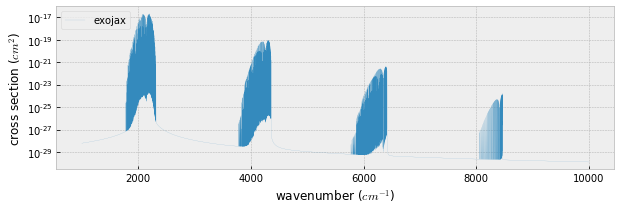

In [47]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(nus,xsv,lw=0.1,label="exojax")
plt.yscale("log")
plt.xlabel("wavenumber ($cm^{-1}$)")
plt.ylabel("cross section ($cm^{2}$)")
plt.legend(loc="upper left")
plt.savefig("co_hitran.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

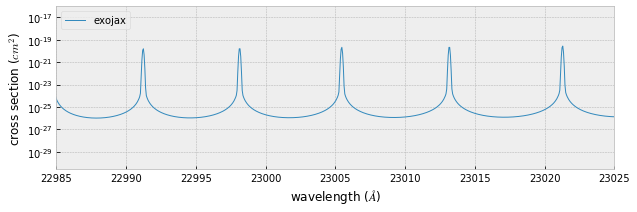

In [48]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(1.e8/nus,xsv,lw=1,label="exojax")
plt.yscale("log")
plt.xlabel("wavelength ($\AA$)")
plt.ylabel("cross section ($cm^{2}$)")
plt.xlim(22985.,23025)
plt.legend(loc="upper left")
plt.savefig("co_hitran.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

### Note 1.

When you make numatrix, use float64 for wavenumber bin and line center.

Below, we see the difference of opacity between float64 case and float 32.

In [50]:
#computing cross section using float32 wavenumber and line center
Ni=int(len(nus)/d)
xsv_32=[]
for i in (range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    numatrix=make_numatrix0(np.float32(nus[s:e]),np.float32(ll))
    xsv_32 = np.concatenate([xsv_32,xsvector(numatrix,sigmaD,gammaL,Sij)])

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 b

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 b

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 b

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 b

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 b

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 b

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 b

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 b

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 b

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 b

Warning!: Type is not np.float64 but  float32
Warning!: Type is not np.float64 but  float32


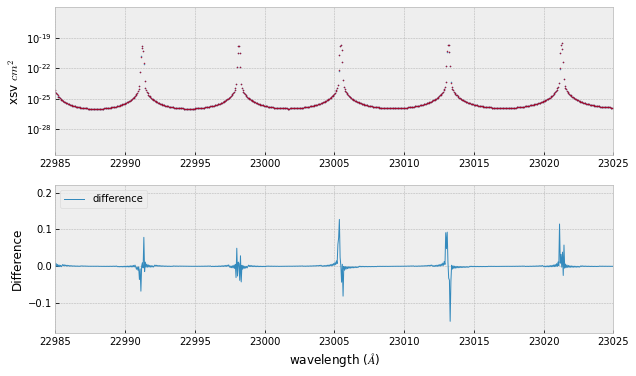

In [51]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(211)
plt.plot(1.e8/nus,xsv,".",lw=1,label="64",markersize=1)
plt.plot(1.e8/nus,xsv_32,".",lw=1,label="32",markersize=1)
plt.xlim(22985.,23025)
plt.yscale("log")
plt.ylabel("xsv $cm^{2}$")
ax=fig.add_subplot(212)
plt.plot(1.e8/nus,(xsv_32-xsv)/xsv,lw=1,label="difference")
plt.xlabel("wavelength ($\AA$)")
plt.ylabel("Difference")
plt.xlim(22985.,23025)
plt.legend(loc="upper left")
plt.show()

We found ~ 10 % error when using float32 as an wavenumber and line center